# Отток клиентов банка

### Описание проекта

**Цели и задачи:**

* Проанализировать исторические данные о поведении клиентов банка, расторжении договоров. Спрогнозировать уход клиента из банка.
* Построить модель классификации, метрика качества f1 (минимальное значение 0.59)
* Измерить AUC-ROC, сравнить её значение с f1-мерой.

**Описание данных:**

Исторические данные о поведении клиентов и расторжении договоров с банком.

Источник данных: https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Признаки**

* `RowNumber` — индекс строки в данных
* `CustomerId` — уникальный идентификатор клиента
* `Surname` — фамилия
* `CreditScore` — кредитный рейтинг
* `Geography` — страна проживания
* `Gender` — пол
* `Age` — возраст
* `Tenure` — количество недвижимости у клиента
* `Balance` — баланс на счёте
* `NumOfProducts` — количество продуктов банка, используемых клиентом
* `HasCrCard` — наличие кредитной карты
* `IsActiveMember` — активность клиента
* `EstimatedSalary` — предполагаемая зарплата

**Целевой признак**

* `Exited` — факт ухода клиента

### Структура проекта

1. Подготовка данных
2. Исследование задачи
    * 2.1 Логистическая регрессия
    * 2.2 Решающее дерево
    * 2.3 Случайный лес
    * 2.4 Метод ближайших соседей
3. Борьба с дисбалансом
    * 3.1 Взвешивание классов
    * 3.2 Upsampling и downsampling
4. Тестирование модели
5. Общий вывод

## 1. Подготовка данных

In [2]:
# импортируем необходимые для работы библиотеки
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from imblearn.combine import SMOTETomek

In [3]:
# открываем файл с данными
pth1 = 'Churn.csv'

pth2 = '/datasets/Churn.csv'

if os.path.exists(pth1):
    df = pd.read_csv(pth1)
elif os.path.exists(pth2):
    df = pd.read_csv(pth2)
else:
    print('Something is wrong')

In [4]:
# выведем первые 10 строк таблицы с помощью метода head()
display(df.head(10))
# с помощью метода info() изучим структуры таблицы: типы данных, количество строк, столбцов, пропущенных данных.
df.info()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8.0,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7.0,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4.0,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4.0,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2.0,134603.88,1,1,1,71725.73,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
# проверим наличие явных дубликатов
df.duplicated().sum()

0

**1)** Признаки `RowNumber`, `CustomerId` и `Surname` не несут в себе информации, необходимой для дальнейшей классификации. Удалим их.

In [6]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

---

**2)** Категориальные признаки `Geography` и `Gender` преобразуем методом One-Hot Encoding.

In [7]:
# для преобразования воспользуемся методом pd.get_dummies
# параметр drop_first=True для удаления избыточного столбца данных
df = pd.get_dummies(df, drop_first=True)

---

**3)** В столбце `'Tenure'` есть пропущенные данные. Они могли отсутствовать изначально или быть утеряны из-за сбоев в системе при выгрузке базы.
* Строки с пропущенными значениями нельзя отнести к одной конкретной категории (разный кредитный рейтинг, разное местоположение и доход и тд).
* Попробуем построить модель, предсказывающую данный параметр на основе имеющихся данных.

In [8]:
# сохраним данные с пропущенными значениями 'Tenure' в отдельной переменной
no_tenure_df = df.loc[df['Tenure'].isna()]
features = df.loc[~df['Tenure'].isna()]

In [9]:
# основной целевой признак 'Exited' не будет участвовать в данной модели
features = features.drop('Exited', axis=1)

In [10]:
# в данной модели признак 'Tenure' выступает в качестве целевого
y = features['Tenure']
X = features.drop('Tenure', axis=1)

In [11]:
# разделим данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

Прежде чем проводить обучение, к числовым признакам `CreditScore`, `Age`, `Balance`, `EstimatedSalary`, `NumOfProducts` применим масштабирование с помощью `StandardScaler` библиотеки `sklearn`.

In [12]:
numerics = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary', 'NumOfProducts']
scaler = StandardScaler()
scaler.fit(X_train[numerics])
X_train[numerics] = scaler.transform(X_train[numerics])
X_valid[numerics] = scaler.transform(X_valid[numerics])

Классификацию попробуем провести с помощью модели "Случайный Лес", попробуем оценивать качество модели с помощью `accuracy`.

In [13]:
# в параметрах best_params и best_accuracy будем хранить наилучшие параметры для модели и наивысшую долю правильных предсказаний
best_params = []
best_accuracy = 0
# проходим в циклах по всем выбранным гиперпараметрам
for n_estimators in (1,10):
    for max_depth in range(2,10):
        for min_samples_split in range(2,10):
            for min_samples_leaf in range(1,8):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)
                    # вычисление точности модели методом accuracy_score
                    accuracy = accuracy_score(y_valid, predictions)
                    # если текущее значение точности выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую точность
                    if accuracy > best_accuracy:
                        best_params = [n_estimators, max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_accuracy = accuracy

In [14]:
# вывод наилучшей доли правильных ответов и параметров модели.
print('''Наилучшая доля правильных ответов: {}
Парамтеры модели:
   n_estimators = {}
   max_depth = {}
   min_samples_split = {}
   min_samples_leaf = {}
   criterion = {} '''.format(round(best_accuracy, 2),
                             best_params[0],
                             best_params[1],
                             best_params[2],
                             best_params[3],
                             best_params[4]
                            ))

Наилучшая доля правильных ответов: 0.11
Парамтеры модели:
   n_estimators = 10
   max_depth = 5
   min_samples_split = 4
   min_samples_leaf = 1
   criterion = gini 


* Accuracy модели 11% слишком мал (случайный выбор между 11 классами даст около 9%). Другие модели классификации не улучшили качество классификации.
* Заполним пропуски нетипичным значением **-1**, пропущенные значения будут отдельной категорией.

In [15]:
df.loc[df['Tenure'].isna(), 'Tenure'] = -1
df['Tenure'] = df['Tenure'].astype('object')
df = pd.get_dummies(df, drop_first=True)

Выведем информацию о получившейся таблице.

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Balance            10000 non-null  float64
 3   NumOfProducts      10000 non-null  int64  
 4   HasCrCard          10000 non-null  int64  
 5   IsActiveMember     10000 non-null  int64  
 6   EstimatedSalary    10000 non-null  float64
 7   Exited             10000 non-null  int64  
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
 11  Tenure_0.0         10000 non-null  uint8  
 12  Tenure_1.0         10000 non-null  uint8  
 13  Tenure_2.0         10000 non-null  uint8  
 14  Tenure_3.0         10000 non-null  uint8  
 15  Tenure_4.0         10000 non-null  uint8  
 16  Tenure_5.0         1000

* Данные успешно загружены и проверены на соответствие описанию. Дубликатов нет. Типы данных преобразованы в соответствии с хранимой информацией
* Признаки `RowNumber`, `CustomerId` и `Surname` удалены, так как целевой признак от них никак не зависит.
* Числовые признаки приведены к стандартному виду.
* Категориальные признаки преобразованы методом One-Hot Encoder.
* Попытка построить классификационную модель для заполнения пропусков в признаке `Tenure` не принесла существенных результатов (качество модели 12%, при случайном заполнении 9%). Данный признак преобразован прямым кодированием One-Hot Encoder.

## 2. Исследование задачи

Исследуем баланс классов целевого признака.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

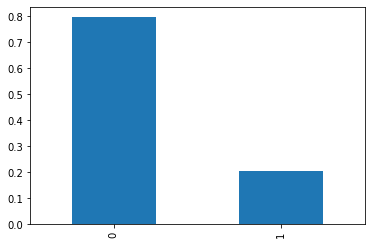

In [17]:
print(df['Exited'].value_counts(normalize=True))
df['Exited'].value_counts(normalize=True).plot(kind='bar')

* Классы несбалансированы. Целевой признак `Exited` распределён примерно 4:1.
* Попробуем обучить различные классификационные модели без учёта дисбаланса классов.
* Для начала разделим данные на признаки и целевой признак.

In [18]:
features = df.drop('Exited', axis=1)
target = df['Exited']

* Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки).
* После разделения применим масштабирование к числовым признакам.

In [19]:
# разделение проведём с помощью функции train_test_split библиотеки sklearn
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

In [20]:
# проводим масштабирование функцией StandardScaler библиотеки sklearn
scaler.fit(X_train[numerics])
X_train[numerics] = scaler.transform(X_train[numerics])
X_valid[numerics] = scaler.transform(X_valid[numerics])
X_test[numerics] = scaler.transform(X_test[numerics])

In [21]:
# выведем размеры получившихся выборок
print('Размеры наборов данных:')
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test:  ', X_test.shape)

Размеры наборов данных:
X_train:  (6000, 21)
X_valid:  (2000, 21)
X_test:   (2000, 21)


### 2.1 Логистическая регрессия

Инициируем модель логистической регрессии `LogisticRegression`

Выделим гиперпараметры для настройки модели:
* `С` - инверсия силы регуляризации

Критерием проверки качества модели будет `f1` и `roc_auc`.

In [22]:
# в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
best_params_f1 = []
best_f1 = 0
# аналогично для roc_auc метрики.
best_params_roc_auc = []
best_roc_auc = 0.5

# проходим в циклах по всем выбранным гиперпараметрам
for C in range(1, 100):
    # инициация модели с текущими гиперпараметрами
    model_lr_clf = LogisticRegression(random_state=123,
                                      C=C,
                                      max_iter=1000)
    # обучение модели на тренировочной выборке
    model_lr_clf.fit(X_train, y_train)
    # поиск предсказаний модели на валидационной выбоке
    predictions = model_lr_clf.predict(X_valid)

    # вычисление f1 модели методом f1_score
    f1 = f1_score(y_valid, predictions)
    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
    # сохраняем параметры модели и текущую метрику f1
    if f1 > best_f1:
        best_params_f1 = [C]
        best_f1 = f1
    # аналогично для метрики roc_auc
    roc_auc = roc_auc_score(y_valid, predictions)
    if roc_auc > best_roc_auc:
        best_params_roc_auc = [C]
        best_roc_auc = roc_auc

In [23]:
# вывод наилучшей метрики f1 и параметров модели.
print('''Наилучшая метрика f1: {}
Парамтеры модели:
   C = {} '''.format(round(best_f1, 3),
                             best_params_f1[0]
                            ))

# вывод наилучшей метрики roc_auc и параметров модели.
print('''Наилучшая метрика roc_auc: {}
Парамтеры модели:
   C = {} '''.format(round(best_roc_auc, 3),
                             best_params_roc_auc[0]
                            ))

Наилучшая метрика f1: 0.279
Парамтеры модели:
   C = 5 
Наилучшая метрика roc_auc: 0.574
Парамтеры модели:
   C = 5 


* Наилучшая метрика f1 для логистической регрессии 0.28 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат на других моделях.

### 2.2 Решающее дерево

Инициируем модель решающего дерева `DecisionTreeClassifier`.

Выделим гиперпараметры для настройки модели:
* `max_depth` - максимальная глубина древа
* `min_samples_split` - минимальное количество объектов в узле
* `min_samples_leaf` - минимальное количество объектов в листе
* `criterion` ("gini" или "entropy") - функция измерения качества разделения

Критерием проверки качества модели будет `f1` и `roc_auc`.

In [24]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели решающего дерева
    output: None
    description: функция обучает модель решающего дерева DecisionTreeClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for max_depth in range(2,10):
        for min_samples_split in range(2,6):
            for min_samples_leaf in range(1,10):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_dt_clf = DecisionTreeClassifier(random_state=123,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_dt_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_dt_clf.predict(X_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_roc_auc = roc_auc
    
    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))
    
    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [25]:
decision_tree(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.569
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.711
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 


* Наилучшая метрика f1 для решающего дерева 0.57 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат на других моделях

### 2.3 Случайный лес

Инициируем модель решающего дерева `RandomForestClassifier`.

Выделим гиперпараметры для настройки модели:
* `n_estimators` - количество деревьев
* `max_depth` - максимальная глубина древа
* `min_samples_split` - минимальное количество объектов в узле
* `min_samples_leaf` - минимальное количество объектов в листе

Критерием проверки качества модели будет `f1` и `roc_auc`.

In [26]:
def random_forest(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели случайного леса
    output: None
    description: функция обучает модель решающего дерева RandomForestClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for n_estimators in range(30,40):
        for max_depth in range(12,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf, 
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)

                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [27]:
random_forest(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.575
    Парамтеры модели:
       n_estimators = 30
       max_depth = 16
       min_samples_split = 2
       min_samples_leaf = 3 

Наилучшая метрика roc_auc: 0.707
    Парамтеры модели:
       n_estimators = 30
       max_depth = 16
       min_samples_split = 2
       min_samples_leaf = 3 


* Наилучшая метрика f1 для случайного леса 0.58 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат на других моделях.

### 2.4 Метод ближайших соседей 

In [28]:
# в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
best_params_f1 = []
best_f1 = 0
# аналогично для roc_auc метрики.
best_params_roc_auc = []
best_roc_auc = 0.5

# проходим в циклах по всем выбранным гиперпараметрам
for n_neighbors in range(1, 10):
    # инициация модели с текущими гиперпараметрами
    model_kn_clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    # обучение модели на тренировочной выборке
    model_kn_clf.fit(X_train, y_train)
    # поиск предсказаний модели на валидационной выбоке
    predictions = model_kn_clf.predict(X_valid)

    # вычисление f1 модели методом f1_score
    f1 = f1_score(y_valid, predictions)
    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
    # сохраняем параметры модели и текущую метрику f1
    if f1 > best_f1:
        best_params_f1 = [n_neighbors]
        best_f1 = f1
    # аналогично для метрики roc_auc
    roc_auc = roc_auc_score(y_valid, predictions)
    if roc_auc > best_roc_auc:
        best_params_roc_auc = [n_neighbors]
        best_roc_auc = roc_auc

In [29]:
# вывод наилучшей метрики f1 и параметров модели.
print('''Наилучшая метрика f1: {}
Парамтеры модели:
   n_neighbors = {} '''.format(round(best_f1, 3),
                               best_params_f1[0]
                              ))

# вывод наилучшей метрики roc_auc и параметров модели.
print('''Наилучшая метрика roc_auc: {}
Парамтеры модели:
   n_neighbors = {} '''.format(round(best_roc_auc, 3),
                               best_params_roc_auc[0]
                              ))

Наилучшая метрика f1: 0.497
Парамтеры модели:
   n_neighbors = 7 
Наилучшая метрика roc_auc: 0.669
Парамтеры модели:
   n_neighbors = 7 


* Наилучшая метрика f1 для логистической регрессии 0.50 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат, разобравшись с дисбалансом классов.

## 3. Борьба с дисбалансом

* Соотношение значений целевого признака 4:1 (для классов 0 и 1 соответственно)
* Для борьбы с дисбалансом классов попробуем:
    * взвешивание классов (class_weight='balanced')
    * увеличение выборки положительного класса (upsampling)
    * уменьшение выборки отрицательного класса (downsampling)
* Результаты проверим на моделях решающего дерева и случайного леса (они дали наилучший результат при начальном исследовании).

### 3.1 Взвешивание классов

**1) Решающее дерево**

In [30]:
decision_tree(X_train, X_valid, y_train, y_valid, cw='balanced')

Наилучшая метрика f1: 0.565
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 9
       criterion = gini 

Наилучшая метрика roc_auc: 0.751
    Парамтеры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 8
       criterion = gini 


* Взвешивание классов не дало прироста в метрике f1 на решающем дереве.
* Метрика roc_auc увеличилась на **0.04**.
* Отметим, что в данном случае наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.

---

**2) Случайный лес**

In [31]:
random_forest(X_train, X_valid, y_train, y_valid, cw='balanced')

Наилучшая метрика f1: 0.628
    Парамтеры модели:
       n_estimators = 38
       max_depth = 14
       min_samples_split = 2
       min_samples_leaf = 2 

Наилучшая метрика roc_auc: 0.756
    Парамтеры модели:
       n_estimators = 38
       max_depth = 14
       min_samples_split = 2
       min_samples_leaf = 2 


* Метрика f1 для модели "Случайный лес" достигла значения **0.63** на сбалансированной выборке, что удовлетворяет условию технического задания (>0.59).
* Метрика roc_auc увеличилась на **0.05**.
* Наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.

### 3.2 Upsampling и downsampling

* Для увеличения и уменьшения выборок воспользуемся методом `SMOTETomek` библиотеки `imblearn`. Этот метод увеличивает выборку класса меньшинства и уменьшает выборку класса большинства.

In [32]:
# делаем сэмплинг обучающей выборки методом 'SMOTETomek' библиотеки 'imblearn'
smt = SMOTETomek(random_state=123)
X_res, y_res = smt.fit_resample(X_train, y_train)

**1) Решающее дерево**

In [33]:
decision_tree(X_res, X_valid, y_res, y_valid)

Наилучшая метрика f1: 0.59
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 1
       criterion = gini 

Наилучшая метрика roc_auc: 0.749
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 1
       criterion = gini 


---

**2) Случайный лес**

In [34]:
random_forest(X_res, X_valid, y_res, y_valid)

Наилучшая метрика f1: 0.596
    Парамтеры модели:
       n_estimators = 36
       max_depth = 14
       min_samples_split = 2
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.745
    Парамтеры модели:
       n_estimators = 36
       max_depth = 14
       min_samples_split = 2
       min_samples_leaf = 1 


* Метрика f1 для модели "Случайный лес" достигла значения **0.60** на сбалансированной выборке, что удовлетворяет условию технического задания (>0.59).
* Для модели "Решающее дерево" метрика f1 также достигла минимально допустимого значения 0.59 (за меньшее время обучения).
* Наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.
* Стоит отметить, что максимальное значение метрики roc_auc для решающего дерева **0.749** немного выше, чем для случайного леса **0.745**.

**Выводы**

* Взвешивание классов с помощью параметра `class_weight` дало максимальное увеличение метрики f1 для модели "Случайный лес".
* Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост метрики f1 для модели "Случайный лес", однако меньше, чем при взвешивани классов.
* Необходимое качество на валидационной выборке получила модель:
    * Случайный лес:
        * f1 = 0.628
        * n_estimators = 38
        * max_depth = 14
        * min_samples_split = 2
        * min_samples_leaf = 2 

## 4. Тестирование модели

* Проведём обучение полученной модели на всех доступных данных (обучающие + валидационные), сбалансировав классы с помощью взвешивания классов (class_weight='balanced').
* Вычислим метрики f1 и roc_auc на тестовой выборке.

In [35]:
# Перед тестом проводим масштабирование обобщенной выборки (обучающие + валидационные)
scaler.fit(X[numerics])
X[numerics] = scaler.transform(X[numerics])

In [36]:
model_rfc_final = RandomForestClassifier(random_state=123,
                                         n_estimators=38,
                                         max_depth=14,
                                         min_samples_split=2,
                                         min_samples_leaf=2,
                                         class_weight='balanced')
model_rfc_final.fit(X, y)
predictions = model_rfc_final.predict(X_test)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.63, 
 roc_auc = 0.76


**Выводы**

* Удовлетворяющее техническому заданию значение метрики f1 (на тестовой выборке) удалось получить на модели "Случайный лес"
    * Метрика f1 = 0.63
    * Метрика roc_auc = 0.76

## 5. Общий вывод

* Произведена предобработка данных.
    * Числовые признаки приведены к стандартному виду. Категориальные признаки преобразованы методом One-Hot Encoder.
    * Попытка построить классификационную модель для заполнения пропусков В признаке `Tenure` не принесла существенных результатов (качество модели 11%, при случайном заполнении 9%). Данный признак преобразован прямым кодированием One-Hot Encoder.
* Проведён анализ моделей без учёта дисбаланса классов.
    * Целевой признак распределён в сооотношении **4:1**.
    * Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно.
    * Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" и "Метод ближайших соседей" без учёта дисбаланса классов. Максимальное значение метрики **f1 = 0.58** получено при обучении модели случайного леса.
    * Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики **roc_auc = 0.711** достигнуто при обучении модели решающего дерева.
    * Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров.
* Проведён анализ дисбаланса классов
    * Взвешивание классов с помощью параметра `class_weight` дало максимальное увеличение метрики f1 для модели "Случайный лес".
    * Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост метрики f1 для модели "Случайный лес", однако меньше, чем при взвешивани классов.
    * Необходимое качество **на валидационной выборке** получила модель:
        * **Случайный лес:**
            * **f1 = 0.628**
            * **n_estimators = 38**
            * **max_depth = 14**
            * **min_samples_split = 2**
            * **min_samples_leaf = 2**
* Проведено тестирование полученных моделей на тестовой выборке:
    * Значение метрики **f1 на тестовой выборке**:
        * **f1 = 0.63**
        * **roc_auc = 0.76**